# Hybird LSTM for Lorenz96

In [ ]:

import pandas as pd
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:

print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.9.2
Running on TPU  ['10.25.250.154:8470']


### We import the data and the empirical data

In [ ]:

data = pd.read_csv('/content/drive/My Drive/Data_1millon_8col.csv', header=None, index_col=None)
data_hybrid = pd.read_csv('/content/drive/My Drive/HYBRID_Data_1millon_8col.csv', header=None, index_col=None) 


In [ ]:
print(data.shape, data_hybrid.shape)


(1000000, 8) (1000000, 8)


In [ ]:

# - train 500K (primeros 500K)
# - val 10K (siguientes 40K)
# - test 2K (siguientes 2K)
# training size parameters
train_size = 500000
val_size = 40000
test_size = 2000

# lookback

lookback = 5 

def LSTM_datasets(data,train_size,val_size,test_size, data_hybrid):
    samples = train_size + val_size + test_size
    ssamples =samples 
    nfeatures = data.shape[1]
    
    sdata = np.transpose(data.values)[:,:samples]
    hdata = np.transpose(data_hybrid.values)[:,:ssamples]

    X_temps = {}
    X_temph = {}
    for i in range(lookback):    
        X_temps[i] = sdata[:,i:samples-(lookback-i-1)]
        X_temph[i] = hdata[:,i:ssamples-(lookback-i-1)]

    X_s = X_temps[0]
    X_h = X_temph[0]
    for i in range(lookback-1):
        X_s = np.vstack([X_s,X_temps[i+1]])
        X_h = np.vstack([X_h,X_temph[i+1]])

    X_s = np.transpose(X_s)
    Y_s = np.transpose(sdata[:,lookback:samples])
    X_h = np.transpose(X_h)
    Y_h = np.transpose(hdata[:,lookback:ssamples])
    
# We define the value for the training set
    Xtrain_s = X_s[:train_size,:]
    Ytrain_s = Y_s[:train_size,:]

    Xval = X_s[train_size:train_size+val_size,:]
    Yval = Y_s[train_size:train_size+val_size,:]

    Xtest = X_s[train_size+val_size:,:]
    Ytest = Y_s[train_size+val_size:,:]
# We use the hibrid set for the training set 
    Xtrain_h = X_h[:train_size,:]
    Ytrain_h = Y_h[:train_size,:] 

    
    Xtrain_1 = Xtrain_s.reshape((Xtrain_s.shape[0], lookback, nfeatures)) # normal
    Xtrain_2 = Xtrain_h.reshape((Xtrain_h.shape[0], lookback, nfeatures)) # hirbido

    Xtrain = np.concatenate((Xtrain_1, Xtrain_2), axis = 0)
    Ytrain = np.concatenate((Ytrain_s, Ytrain_h), axis = 0)

    Xval = Xval.reshape((Xval.shape[0], lookback,nfeatures))
    Xtest = Xtest.reshape((Xtest.shape[0], lookback,nfeatures))


    print("Xtrain shape = ", Xtrain.shape, "Ytrain shape = ", Ytrain.shape)
    print("Xtrain_H shape = ", Xtrain_h.shape, "Ytrain shape = ", Ytrain_s.shape)
    print("Xtrain_S shape = ", Xtrain_s.shape, "Ytrain shape = ", Ytrain_h.shape)
    
    print("Xval shape =   ", Xval.shape, "  Yval shape =   ", Yval.shape)
    print("Xtest shape =  ", Xtest.shape, " Ytest shape =  ", Ytest.shape)
    
    return Xtrain, Ytrain, Xtrain_1, Ytrain_s, Xtrain_2, Ytrain_h, Xval, Yval, Xtest, Ytest, nfeatures


nhidden = 50
opt = keras.optimizers.Adam(learning_rate=0.0001)
def LSTM_model( Xtrain, Ytrain, Xtrain_s, Ytrain_s, Xtrain_h, Ytrain_h, nfeatures, nhidden):
    epochs=10

    model = Sequential()
    model.add(LSTM(nhidden, return_sequences=True, input_shape=(Xtrain_s.shape[1], Xtrain_s.shape[2]))) 
    model.add(LSTM(nhidden,  input_shape=(Xtrain_h.shape[1], Xtrain_h.shape[2])))
    model.add(Dense(nfeatures))
    model.compile(loss='mse', optimizer=opt)
    model.summary()
    
    # fit network
    history = model.fit(Xtrain,Ytrain,
                        epochs=epochs,
                        batch_size=64,  
                        verbose=1, 
                        shuffle=True)


    return model, history


# ## Test the model on test data

# test model on set aside test set

def model_predict(model,Xtest):
    ypred = np.zeros((Xtest.shape[0],nfeatures))

    for i in range(Xtest.shape[0]):  
        if i ==0:
            tt = Xtest[0,:,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt) 
        elif i < lookback:
            tt = Xtest[i,:,:].reshape((1,lookback,nfeatures))
            u = ypred[:i,:]
            tt[0,(lookback-i):lookback,:] = u
            ypred[i,:] = model.predict(tt)
        else:
            tt = ypred[i-lookback:i,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt)
    return ypred




In [ ]:
%%time
# ## Run everything

Xtrain, Ytrain, Xtrain_s,Ytrain_s,Xtrain_h,Ytrain_h,Xval,Yval,Xtest,Ytest,nfeatures =LSTM_datasets(data, train_size, val_size, test_size, data_hybrid)
model,history = LSTM_model(Xtrain, Ytrain,Xtrain_s,Ytrain_s,Xtrain_h,Ytrain_h,nfeatures,nhidden)
ypred = model_predict(model,Xtest)




Xtrain shape =  (1000000, 5, 8) Ytrain shape =  (1000000, 8)
Xtrain_H shape =  (500000, 40) Ytrain shape =  (500000, 8)
Xtrain_S shape =  (500000, 40) Ytrain shape =  (500000, 8)
Xval shape =    (40000, 5, 8)   Yval shape =    (40000, 8)
Xtest shape =   (1996, 5, 8)  Ytest shape =   (1995, 8)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             11800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 8)                 408       
                                                                 
Total params: 32,408
Trainable params: 32,408
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
15625/156

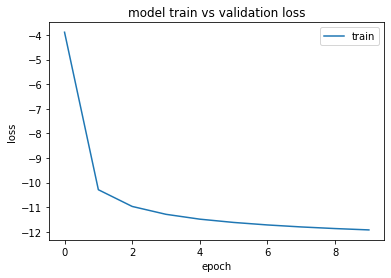

In [ ]:
loss=np.log(history.history['loss'])

plt.plot(loss)

plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Error

**For the analisis on the error we use two parameters**

### **The L2 norm**

$$ e(t)=[\frac{||X_{true}-X_{pred}||}{(||X_{true}||)}]
$$

las ||*|| this is the L2 norm $\sqrt{\sum_{n=1}^{n} (X_t^2) }$

[*] eaverage between the 8 iterations


(*) average set $Δt=2000$

### **The mean squared error**

$$RMSE_t=\sqrt{\frac{1}{V}\sum_{i=1}^{V} ||X_{true}^i-X_{pred}^i||^2 }
$$

In [ ]:
def L2_norm(x,x_p,len,n):

  error_L2=np.zeros([len])
  for t in range(len):
    error_L2[t]=np.sum((np.sqrt(np.sum((x[t,:]-x_p[t,:])**2)))/(np.sum((np.sqrt(np.sum((x[t,:])**2))))/len))/n
  return error_L2

  
def RMSE(x,x_p,len,n):
  error=np.zeros([len])
  for t in range(len):
    error[t]=np.sqrt(sum((x[t,:]-x_p[t,:])**2)/n)
  return error

In [ ]:
Ypred=ypred[:-1,:]
Ypred.shape, Ytest[:,7].shape
XX = np.arange(2000-lookback)


error_cuadratico_medio=RMSE(Ytest, Ypred,len=(2000-lookback),n=int(np.array(Ypred[0].shape)))
error_L2=L2_norm(Ytest, Ypred,len=(2000-lookback),n=int(np.array(Ypred[0].shape)))

print(error_cuadratico_medio.shape, error_L2.shape)

(1995,) (1995,)
